In [2]:
import os, sys, time
import pickle
import numpy as np
from Visa_Source_lib import *
import pyvisa as visa

import matplotlib.pyplot as plt

RECOrdlength = "5E6"

def get_time():
    gm_time = time.gmtime() 
    mk_time = time.mktime(gm_time)
    return str(int(mk_time))

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def setup(add, SCALE=(80/400000) ): #str(0.5/396000)):
    rm = visa.ResourceManager()
    scope = rm.open_resource(add)
    scope.timeout = 80000 # ms
    scope.write('*cls') # clear ESR
    scope.write('FPAnel:PRESS DEFaultsetup')
    scope.write('FPAnel:PRESS MENUOff')
    #scope.write('SELECT:CH3 1')
    scope.write('SELECT:CH1 1')

    #scope.write('autoset EXECUTE')
    scope.write('HORizontal:RECOrdlength '+RECOrdlength )
    scope.write('DISPLAY:INTEnsITY:WAVEFORM 100')

    scope.write('TRIGger:A:EDGE:SOUrce CH1')
    scope.write('TRIGger:A:LEVel 1')
    scope.write('TRIGger:A:TYPe EDGe')
    scope.write('TRIGger:A:MODe NORMal')
    scope.write('TRIGger:A:EDGE:SLOpe FALL')

    #scope.write('CURSor:FUNCtion SCREEN')
    
    #scope.write('acquire:state 0')
    #scope.write('acquire:stopafter SEQUENCE') 
    #scope.write('acquire:state 1')
    scope.write('HORizontal:RECOrdlength '+RECOrdlength )
    scope.write('HORIZONTAL:DELay:TIME '+str(SCALE*4))
    scope.write('HORIZONTAL:SCALE '+str(SCALE))

    scope.write('CH1:POSition 0.5')
    #scope.write('CH3:POSition -2.5')
    
    scope.close()
    rm.close()


def get_rawdata(channel, visa_address ,SCALE=(80/400000), filename=""):
    rm = visa.ResourceManager()
    scope = rm.open_resource(visa_address)
    scope.timeout = 80000 # ms
    scope.encoding = 'latin_1'
    scope.read_termination = '\n'
    scope.write_termination = None

    #scope.write('*rst') # reset
    #t1 = time.perf_counter()
    #r = scope.query('*opc?') # sync
    #t2 = time.perf_counter()
    #print('reset time: {}'.format(t2 - t1))

    #scope.write('autoset EXECUTE') # autoset
    t3 = time.perf_counter()
    r = scope.query('*opc?') # sync
    t4 = time.perf_counter()
    #print('autoset time: {} s'.format(t4 - t3))

    scope.write('HORizontal:RECOrdlength '+ RECOrdlength )
    scope.write('HORizontal:SAMPLERate 100e5')
    scope.write('HORIZONTAL:SCALE '+str(SCALE))

    scope.write('header 0')
    scope.write('data:encdg SRIBINARY')
    scope.write('data:source '+channel) 
    scope.write('data:start 1')
    record = int(scope.query('horizontal:recordlength?'))
    scope.write('data:stop {}'.format(record)) 
    scope.write('wfmoutpre:byt_n 1') 

    scope.write('acquire:state 0')
    scope.write('acquire:stopafter SEQUENCE') 
    scope.write('acquire:state 1')

    #t5 = time.perf_counter()
    #r = scope.query('*opc?') # sync
    #t6 = time.perf_counter()
    #print('acquire time: {} s'.format(t6 - t5))

    # data query
    t7 = time.perf_counter()
    bin_wave = scope.query_binary_values('curve?', datatype='b', container=np.array, chunk_size =1024**2)
    t8 = time.perf_counter()
    print('transfer time: {} s'.format(t8 - t7))

    # retrieve scaling factors
    tscale = float(scope.query('wfmoutpre:xincr?'))
    tstart = float(scope.query('wfmoutpre:xzero?'))
    vscale = float(scope.query('wfmoutpre:ymult?')) # volts / level
    voff = float(scope.query('wfmoutpre:yzero?')) # reference voltage
    vpos = float(scope.query('wfmoutpre:yoff?')) # reference position (level)

    # error checking
    r = int(scope.query('*esr?'))
    print('event status register: 0b{:08b}'.format(r))
    r = scope.query('allev?').strip()
    print('all event messages: {}'.format(r))

    scope.close()
    rm.close()

    # create scaled vectors
    # horizontal (time)
    total_time = tscale * record
    tstop = tstart + total_time
    scaled_time = np.linspace(tstart, tstop, num=record, endpoint=False)
    # vertical (voltage)
    unscaled_wave = np.array(bin_wave, dtype='double') # data type conversion
    CLK_scaled_wave = (unscaled_wave - vpos) * vscale + voff
    #CLK_filename = [(idx, item) for idx,item in enumerate(CLK_scaled_wave, start=1)]
    print("find_nearest:", find_nearest(CLK_scaled_wave, 1.26))
    with open("pt_tmp/"+get_time()+"_"+channel+".txt", "wb") as fp:   #Pickling
        pickle.dump(CLK_scaled_wave, fp)

    #scaled_time = [(idx, item) for idx,item in enumerate(scaled_time, start=1)]
    with open("pt_tmp/"+get_time()+"_"+channel+"_time.txt", "wb") as fp:   #Pickling
        pickle.dump(scaled_time, fp)

    return CLK_scaled_wave, scaled_time



transfer time: 1.0960349999999996 s
event status register: 0b00100000
all event messages: 104,"Data type error; Unrecognized character data; data:source 1"
find_nearest: 0
[-5.62 -5.62 -5.62 ... -5.62 -5.62 -5.62]


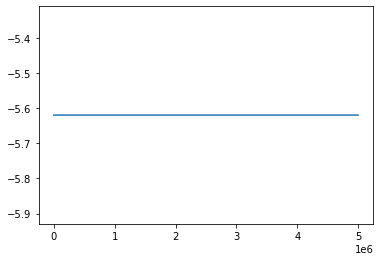

In [3]:

#setup("USB0::0x0699::0x0405::C022392::INSTR", 1)
setup("USB0::0x0699::0x0405::C022392::INSTR", SCALE = 0.005)
CLK_scaled_wave, scaled_time = get_rawdata("1", "USB0::0x0699::0x0405::C022392::INSTR", SCALE = 0.005)
print(CLK_scaled_wave)
plt.plot(CLK_scaled_wave)
plt.show()

c:\Users\10812017\AppData\Local\Programs\Python\Python37\lib\site-packages\pyvisa\highlevel.py:3355: FutureWarning: get_instrument is deprecated and will be removed in 1.12, use open_resource instead.
  FutureWarning,


0.04 0.0 140.5 2e-10


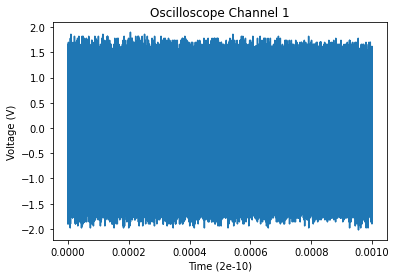

In [58]:
import pyvisa as visa
import numpy as np
from struct import unpack
import pylab

#scope = visa.instrument('USB0::0x0699::0x0401::No_Serial::INSTR')

rm = visa.ResourceManager()
scope = rm.get_instrument("USB0::0x0699::0x0405::C022392::INSTR")

scope.write('DATA:SOU CH1')
scope.write('DATA:WIDTH 1')
scope.write('DATA:ENC RPB')

ymult = float(scope.query('WFMPRE:YMULT?'))
yzero = float(scope.query('WFMPRE:YZERO?'))
yoff = float(scope.query('WFMPRE:YOFF?'))
xincr = float(scope.query('WFMPRE:XINCR?'))

print(ymult, yzero, yoff, xincr)


scope.write('CURVE?')
data_ch1 = scope.read_raw()
headerlen = 2 + int(data_ch1[1])
header = data_ch1[:headerlen]
ADC_wave_ch1 = data_ch1[headerlen:-1]

ADC_wave_ch1 = np.array(unpack('%sB' % len(ADC_wave_ch1),ADC_wave_ch1))

Volts_ch1 = (ADC_wave_ch1 - yoff) * ymult  + yzero

Time = np.arange(0, xincr * len(Volts_ch1), xincr)

pylab.title('Oscilloscope Channel 1')
pylab.ylabel('Voltage (V)')
pylab.xlabel('Time ('+ str(xincr) + ')')
pylab.plot(Time, Volts_ch1)
pylab.show()
rm.close()
scope.close()

In [59]:

def find_timedif(Rawdata, Time):
    delta = 1
    avg = sum(Rawdata)/len(Rawdata)
    #print((avg)*delta)

    tmp = []
    for index, val in enumerate(Rawdata):
        if val >= (avg)*delta:
            tmp.append([index, val])

    pk2pk_time = []
    avg_dif_time = []
    for index, val in enumerate(tmp):
        if index < len(tmp)-1:
            #print(tmp[index+1][0] - val[0])
            time_dif = Time[tmp[index+1][0] ]- Time[val[0]]
            if (time_dif) >= 0.0002:
                #print(time_dif)
                pk2pk_time.append([time_dif, [val[0], val[1]], [tmp[index+1][0], tmp[index+1][1]]])
                avg_dif_time.append(time_dif)
    if avg_dif_time != []:
        avg_time = sum(avg_dif_time)/len(avg_dif_time)
    return pk2pk_time, avg_dif_time

In [60]:
pk2pk_time = []
pk2pk_time, avg_time = find_timedif(Volts_ch1, Time)
print(len(pk2pk_time), avg_time)

0 []


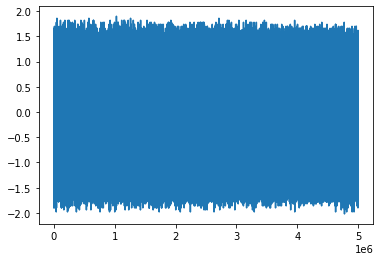

In [61]:
import matplotlib.pyplot as plt
for pk2pk_val in pk2pk_time:
    plt.scatter(pk2pk_val[1][0], pk2pk_val[1][1])
    plt.scatter(pk2pk_val[2][0], pk2pk_val[2][1])

plt.plot(Volts_ch1)
plt.show()